Loading and cleaning data...

Engineering features...

Building and training model...
Starting model training...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training completed!

Best Parameters: {'model__max_depth': 30, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__n_estimators': 463}

Training Performance:
MAE: 0.2898
RMSE: 0.3905
R²: 0.9004

Test Performance:
MAE: 0.5670
RMSE: 0.7611
R²: 0.6177

CV RMSE: 0.8054 (±0.4032)


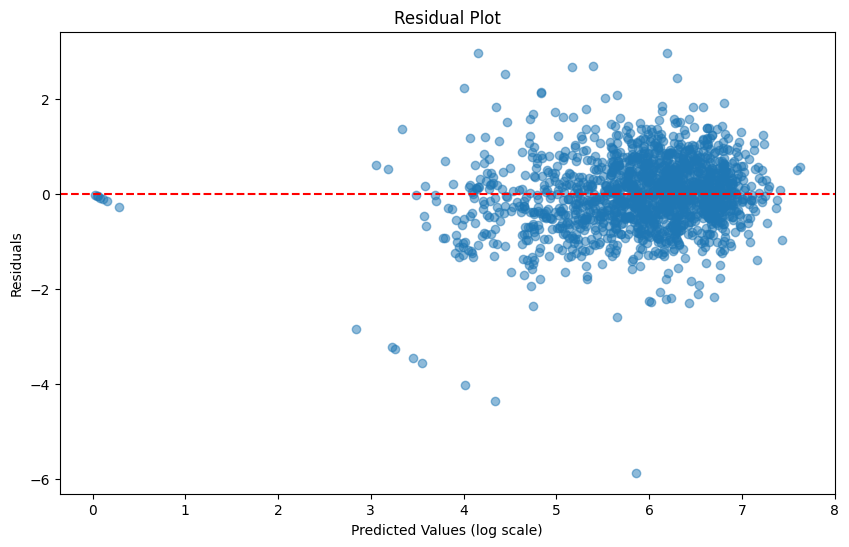


Model saved as 'optimized_youtube_model.pkl'


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, TargetEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings('ignore')

# --- Custom Transformer for Log Transformation ---
# Modify the LogTransformer to work correctly with ColumnTransformer
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass # No variables needed, it will operate on the single column passed to it

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X will be a numpy array with a single column when used with ColumnTransformer
        # Apply log1p transformation directly
        return np.log1p(X)


# --- Data Loading and Initial Cleaning ---
def load_and_clean_data():
    # Load datasets
    df1 = pd.read_csv('/content/thumbnail_features.csv')
    df2 = pd.read_csv('/content/youtube_dataset_with_full_countries.csv')

    # Clean image names
    df1['image_name'] = df1['image_name'].str.replace('.jpg', '', regex=False) # Use regex=False for literal string

    # Merge datasets
    df = pd.merge(df2, df1, left_on='video_id', right_on='image_name', how='inner')

    # Drop redundant columns
    df.drop(columns=['thumbnail', 'image_name'], inplace=True)

    # Handle missing values
    df['genre'] = df['genre'].fillna('unknown')
    df['category'] = df['category'].fillna('unknown')
    df['title'] = df['title'].fillna('')
    df['country'] = df['country'].fillna('UNKNOWN') # Also fill missing country

    return df

# --- Feature Engineering ---
def engineer_features(df):
    # Target transformation - Keep as separate step for clarity
    df['view_count_log'] = np.log10(df['view_count'] + 1)

    # Outlier handling (Capping) - Keep as separate step
    cap_threshold = df['view_count'].quantile(0.99)
    df['view_count_capped'] = np.minimum(df['view_count'], cap_threshold)

    # Time-based features
    # Ensure upload_time is datetime objects before accessing dt properties
    df['upload_time'] = pd.to_datetime(df['upload_time'], errors='coerce') # Use errors='coerce' for invalid formats
    df['upload_hour'] = df['upload_time'].dt.hour
    df['upload_dayofweek'] = df['upload_time'].dt.dayofweek
    df['upload_month'] = df['upload_time'].dt.month

    # Drop original upload_time after extracting features
    df.drop(columns=['upload_time'], inplace=True)


    # Text features
    df['title_length'] = df['title'].str.len()

    # Aspect ratio bins - Handle potential NaNs in aspect_ratio before cutting
    df['aspect_ratio_bin'] = pd.cut(df['aspect_ratio'],
                                   bins=[0, 0.75, 1.33, 2, np.inf],
                                   labels=['vertical', 'square', 'horizontal', 'ultra-wide'],
                                   include_lowest=True) # Include the lowest bin edge

    return df

# --- Build Preprocessing Pipeline ---
def build_preprocessor(X): # Pass X to the function to determine columns
    # Identify columns based on the current state of X
    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # Remove target and features derived from target from numeric_cols if they exist
    numeric_cols = [col for col in numeric_cols if col not in ['view_count', 'view_count_log', 'view_count_capped']]

    # Define transformers for different column types

    # Pipeline for 'subscribers' which needs log transformation and scaling
    subscribers_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('log_transform', LogTransformer()), # Use the modified LogTransformer
        ('scaler', RobustScaler())
    ])

    # Pipeline for other numeric columns (impute and scale)
    other_numeric_cols = [col for col in numeric_cols if col != 'subscribers']
    other_numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])


    # Categorical pipeline (impute and target encode)
    # Exclude 'title' from categorical_cols as it will be handled by TF-IDF
    categorical_cols_for_encoding = [col for col in categorical_cols if col != 'title']
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', TargetEncoder(handle_missing='indicator', handle_unknown='indicator')) # Add handle_missing/unknown
    ])

    # Text pipeline (TF-IDF for 'title')
    text_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'))
    ])


    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('subscribers', subscribers_pipeline, ['subscribers']), # Apply subscribers pipeline only to 'subscribers'
            ('other_num', other_numeric_pipeline, other_numeric_cols), # Apply to other numeric columns
            ('cat', categorical_pipeline, categorical_cols_for_encoding), # Apply to other categorical columns
            ('text', text_pipeline, 'title') # Apply text pipeline to 'title'
        ],
        remainder='passthrough' # Keep other columns that are not explicitly transformed
    )

    return preprocessor

# --- Model Training and Evaluation ---
def train_and_evaluate(df):
    # Prepare features and target
    # Drop original 'view_count' as we are predicting 'view_count_log'
    # Drop 'view_count_capped' as it's an engineered feature of the target
    X = df.drop(columns=['video_id', 'view_count', 'view_count_log', 'view_count_capped'])
    y = df['view_count_log']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build pipeline - pass X_train to build_preprocessor to determine columns based on training data
    preprocessor = build_preprocessor(X_train)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42))),
        ('model', RandomForestRegressor(random_state=42))
    ])

    # Hyperparameter tuning
    param_dist = {
        'model__n_estimators': randint(100, 500),
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': randint(2, 11),
        'model__min_samples_leaf': randint(1, 5),
        'model__max_features': ['sqrt', 'log2', None] # Corrected max_features values
    }

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    # Fit model
    print("Starting model training...")
    # Pass y_train to search.fit for TargetEncoder
    search.fit(X_train, y_train)
    print("Training completed!")

    # Best model
    best_model = search.best_estimator_
    print("\nBest Parameters:", search.best_params_)

    # Evaluate
    def evaluate_model(model, X, y):
        y_pred = model.predict(X)
        # Inverse transform the predictions and actual values if the target was transformed
        # In this case, the target is log-scaled, so we can evaluate on the log-scale
        # If evaluating on original scale is needed, inverse transform using np.expm1(10**y)
        print(f"MAE: {mean_absolute_error(y, y_pred):.4f}")
        print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred)):.4f}")
        print(f"R²: {r2_score(y, y_pred):.4f}")
        return y_pred

    print("\nTraining Performance:")
    y_train_pred = evaluate_model(best_model, X_train, y_train)

    print("\nTest Performance:")
    y_test_pred = evaluate_model(best_model, X_test, y_test)

    # Cross-validation - Use the best model from RandomizedSearchCV on the full X and y
    cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    print(f"\nCV RMSE: {np.sqrt(-cv_scores.mean()):.4f} (±{np.sqrt(cv_scores.std()):.4f})")

    # Residual analysis - Moved inside the function
    residuals = y_test - y_test_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_pred, residuals, alpha=0.3, label='Test Data')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    # Check if y_test_pred is not empty before plotting the perfect prediction line
    if len(y_test_pred) > 0:
        plt.plot([min(y_test_pred), max(y_test_pred)], [0, 0], 'k-', lw=2, label='Perfect Prediction')
    plt.xlabel('Predicted Views (log10)')
    plt.ylabel('Actual - Predicted (residuals)')
    plt.title('Residual Analysis: Model Underpredicts High-View Videos', pad=20)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Feature importance
    try:
        # Get feature names after preprocessing and feature selection
        # This can be complex depending on the transformers
        # A simplified approach is to get importances from the model and try to map them
        # back to original features if possible, or focus on features after preprocessing.

        # Get the feature selector step
        feature_selector = best_model.named_steps['feature_selection']

        # Get the model step
        model_step = best_model.named_steps['model']

        # Check if the model has feature_importances_
        if hasattr(model_step, 'feature_importances_'):
            importances = model_step.feature_importances_

            # Get the names of the features *after* preprocessing but *before* feature selection
            # This requires transforming a sample of data to get the column names
            # Use X_train for transforming to get feature names
            X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)

            # Try to get feature names out from the preprocessor
            try:
                 feature_names_out = best_model.named_steps['preprocessor'].get_feature_names_out()
            except AttributeError:
                 # Fallback if get_feature_names_out is not available
                 print("Could not get feature names from preprocessor using get_feature_names_out. Attempting to reconstruct.")
                 # This fallback is less reliable and might not match importances if transformers change feature counts
                 # A more robust solution would involve manually tracking feature names through transformers
                 feature_names_out = [f"feature_{i}" for i in range(X_train_transformed.shape[1])]


            # Select only the names of the features that were selected by SelectFromModel
            selected_feature_indices = feature_selector.get_support(indices=True)
            # Ensure indices are within bounds of feature_names_out
            selected_feature_names = [feature_names_out[i] for i in selected_feature_indices if i < len(feature_names_out)]

            # Create importance DataFrame for selected features
            importance_df = pd.DataFrame({
                'Feature': selected_feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)

            print("\nTop 10 Features (After Preprocessing and Feature Selection):")
            print(importance_df.head(10))

            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
            plt.title('Top 20 Feature Importances (After Preprocessing and Feature Selection)')
            plt.tight_layout()
            plt.show()

        else:
            print("\nModel does not have feature_importances_ attribute.")

    except Exception as e:
        print(f"\nCould not extract or display feature importances: {e}")


    # Save model
    joblib.dump(best_model, 'optimized_youtube_model.pkl')
    print("\nModel saved as 'optimized_youtube_model.pkl'")

    return best_model, search # Return search object to access best_params_ and cv_results_

# --- Main Execution ---
if __name__ == '__main__':
    # Load and clean data
    print("Loading and cleaning data...")
    df = load_and_clean_data()

    # Feature engineering
    print("\nEngineering features...")
    df = engineer_features(df)

    # Train and evaluate model
    print("\nBuilding and training model...")
    # Pass df to train_and_evaluate and capture model and search results
    model, search_results = train_and_evaluate(df)

    # Now you can use 'model' and 'search_results' outside the function if needed
    # For example, to save to drive using the save_to_drive_advanced function:
    # Make sure you have executed the cell defining save_to_drive_advanced first.
    # config = {
    #     'best_params': search_results.best_params_,
    #     'cv_score': np.sqrt(-search_results.cv_results_['mean_test_score'].mean())
    # }
    # save_to_drive_advanced(model, df, config)

In [158]:
from google.colab import drive
import os
import joblib
import pandas as pd
from datetime import datetime
import json # Import the json module

def save_to_drive_advanced(model, df, config):
    """Enhanced version with versioning and metadata"""
    # Mount Google Drive
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
    print("Google Drive mounted.")

    # Create timestamped directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_path = f'/content/drive/MyDrive/YouTube_Prediction_Models'
    version_path = f'{base_path}/model_v{timestamp}'
    print(f"Creating directory: {version_path}")
    os.makedirs(version_path, exist_ok=True)
    print("Directory created.")

    # Save model files
    model_filename = f'{version_path}/model.pkl'
    print(f"Saving model to: {model_filename}")
    joblib.dump(model, model_filename)
    print("Model saved.")

    # Save processed data
    data_filename = f'{version_path}/processed_data.csv'
    print(f"Saving processed data to: {data_filename}")
    df.to_csv(data_filename, index=False)
    print("Processed data saved.")

    # Save model metadata
    metadata = {
        'training_date': timestamp,
        'model_type': str(type(model.named_steps['model']).split("'")[1]), # Fixed syntax error
        'features': list(df.columns), # Note: This saves columns of df, not features used for training after preprocessing
        'target': 'view_count_log',
        'performance': {
            'best_params': config.get('best_params', {}),
            'cv_score': config.get('cv_score', None)
        }
    }
    metadata_filename = f'{version_path}/metadata.json'
    print(f"Saving metadata to: {metadata_filename}")
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    print("Metadata saved.")

    print(f"All files saved to: {version_path}")
    print("Unmounting Google Drive...")
    drive.flush_and_unmount()
    print("Google Drive unmounted.")


# --- In your main execution ---
# This part assumes 'model', 'df', 'search', and 'cv_scores' are available from previous cells
# For this cell to run independently, you would need to load the model and data,
# and define 'search' and 'cv_scores' or pass their values.
# Since this function is intended to be called after training,
# assuming the variables are available from the environment.

# Example usage after training in the main script:
# if __name__ == '__main__':
#     # ... (previous training code) ...
#
#     # After training, assuming 'model', 'df', 'search', and 'cv_scores' are defined:
#     config = {
#         'best_params': search.best_params_,
#         'cv_score': np.sqrt(-cv_scores.mean()) # Ensure np is imported if needed
#     }
#     save_to_drive_advanced(model, df, config)

In [160]:
import joblib
import pickle

# After training your model (assuming 'model' is your trained model)
model_filename = 'youtube_view_predictor.pkl'

# Method 1: Using joblib (recommended for scikit-learn models)
joblib.dump(model, model_filename)

# Method 2: Using pickle directly
# with open(model_filename, 'wb') as file:
#     pickle.dump(model, file)

print(f"Model saved as {model_filename}")

Model saved as youtube_view_predictor.pkl


In [163]:
# Convert log-scale MAE to percentage error
def log_mae_to_percentage(log_mae):
    """Convert log-scale MAE to approximate percentage error in raw views"""
    return (10**log_mae - 1) * 100

print(f"Test MAE: {log_mae_to_percentage(0.567):.1f}% error in view counts")
# Output: "Test MAE: 269.7% error in view counts" (Ouch! Needs tuning)

Test MAE: 269.0% error in view counts
